cpu


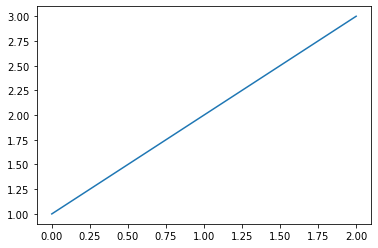

In [2]:
import importlib
from matplotlib import pyplot as plt
plt.plot([1,2,3])
from IPython.display import clear_output
import matplotlib
import numpy as np
import pandas as pd
import pdb
import time
from collections import deque
import torch
import cv2
from Environment.Env import RealExpEnv
from RL.sac import sac_agent, ReplayMemory
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step
from Environment.episode_memory import Episode_Memory
from Environment.get_atom_coordinate import atom_detection, blob_detection, get_atom_coordinate_nm
from skimage import morphology, measure
from Environment.createc_control import Createc_Controller
import glob
from collections import deque
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [230]:
import Env1
importlib.reload(Env1)
from Env1 import RealExpEnv
'''import episode_memory1 
importlib.reload(episode_memory1)
from episode_memory1 import Episode_Memory'''

'import episode_memory1 \nimportlib.reload(episode_memory1)\nfrom episode_memory1 import Episode_Memory'

succeed to connect
(128, 128)


"\ntemplate_path = 'template.png'\n#cv2.imwrite(template_path, template)\n"

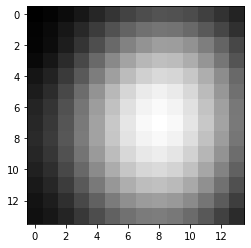

In [2]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
print(img_forward.shape)
top_left, w, h = (4,4), 14, 14
template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)
'''
template_path = 'template.png'
#cv2.imwrite(template_path, template)
'''

In [24]:
step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 4
im_size_nm = 10.027
DactoA = float(createc_controller.stm.getparam('Dacto[A]xy'))
Gain = float(createc_controller.stm.getparam("GainX"))
print('gain:', Gain)
offset_x = -float(createc_controller.stm.getparam('OffsetX'))*DactoA*Gain/10
offset_y = -float(createc_controller.stm.getparam('OffsetY'))*DactoA*Gain/10
print(offset_x, offset_y)
print(float(createc_controller.stm.getparam('PlanDx')), float(createc_controller.stm.getparam('PlanDy')))
offset_x -= float(createc_controller.stm.getparam('PlanDx'))
offset_y -= float(createc_controller.stm.getparam('PlanDy'))

print(offset_x, offset_y)
offset_nm = np.array([190.1,-13.5])
pixel = 128
manip_limit_nm = np.array([189, 195, -11, -5]) #[left, right, up, down]
template_max_y = 25
template_min_x = None
scan_mV = 1000
max_len = 5
env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, template_min_x, scan_mV, max_len)


gain: 10.0
191.53506700000003 -13.581448
-0.09 -0.138
191.62506700000003 -13.443448
succeed to connect


In [4]:
batch_size= 64
LEARNING_RATE = 0.0003
replay_size=1000000

agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=0.0973)

n = 3000
agent.critic.load_state_dict(torch.load('training_4/reward_2_critic_{}.pth'.format(n)))
agent.policy.load_state_dict(torch.load('training_4/reward_2_policy_{}.pth'.format(n)))
agent.alpha = torch.load('training_4/reward_2_alpha_{}.pth'.format(n))
#memory = ReplayMemory(replay_size)
#, map_location=torch.device('cpu')

In [10]:
episode_memory = Episode_Memory()
memory = ReplayMemory(replay_size)

In [11]:
scores_array = []
avg_scores_array = []
alpha = []
temp_nm = []
c_k_min = 2500
eta_0 = 0.996
eta_T = 1.0
n_interactions = 500
max_ep_len = 5
def sac_train(max_steps, num_episodes = 50, episode_start = 0):
    global added_episode
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        eta_t = np.minimum(eta_0 + (eta_T - eta_0)*(i_episode/n_interactions), eta_T)
        episode_reward = 0
        episode_steps = 0
        done = False
        state, info = env.reset()
        show_reset(env.img_info['img_forward'], env.img_info['offset_nm'], env.img_info['len_nm'], 
                   env.atom_start_absolute_nm, env.destination_absolute_nm, env.template_nm, env.template_wh)
        print('old value:',env.old_value)
        #print(env.atom_absolute_nm)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        temp_nm.append(env.template_nm)
        for step in range(max_steps):
            print('step:', step)
            action = agent.select_action(state, eval=True)
            atom_absolute_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            print(reward)
            #print(action, done, reward)
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            memory.push(state,action,reward,next_state,mask)
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            state=next_state
            show_step(env.img_info['img_forward'], env.img_info['offset_nm'], env.img_info['len_nm'], 
                      info['start_nm']+atom_absolute_nm, info['end_nm']+atom_absolute_nm,
                      env.atom_absolute_nm, env.atom_start_absolute_nm, env.destination_absolute_nm, 
                      env.template_nm, env.template_wh, action[4]*env.max_mvolt, 
                      action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt)
            print('template_nm',env.template_nm)
            temp_nm.append(env.template_nm)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory('training_4/eval')
                new_destination_absolute_nm = None
                atom_to_start = env.atom_relative_nm - env.atom_start_relative_nm
                print('atom moved by:', np.linalg.norm(atom_to_start))
                print('Episode reward:', episode_reward)
                show_done(env.img_info['img_forward'], env.img_info['offset_nm'], env.img_info['len_nm'], env.atom_absolute_nm, env.atom_start_absolute_nm, env.destination_absolute_nm, env.template_nm, env.template_wh, reward, new_destination_absolute_nm)
                
                break
                
        '''if (len(memory)>batch_size):
            if i_episode>100:
                train_pi = True
            else:
                train_pi = True
            episode_K = int(episode_steps)
            for k in range(episode_K):
                c_k = max(int(memory.__len__()*eta_t**(k*(max_ep_len/episode_K))), c_k_min)
                #c_k = memory.__len__()
                print('TRAINING!')
                agent.update_parameters(memory, batch_size, c_k, train_pi)'''
        
        scores_array.append(episode_reward)
        if len(scores_array)>100:
            avg_scores_array.append(np.mean(scores_array[-100:]))
        else:
            avg_scores_array.append(np.mean(scores_array))
        print(agent.alpha)
        alpha.append(agent.alpha)
        
        if (i_episode+1)%2==0:
            plot_graph(scores_array,avg_scores_array)
        '''if (i_episode)%20 == 0:
            torch.save(agent.critic.state_dict(), 'training_4/reward_2_critic_{}.pth'.format(i_episode))
            torch.save(agent.policy.state_dict(), 'training_4/reward_2_policy_{}.pth'.format(i_episode))
            torch.save(agent.alpha, 'training_4/reward_2_alpha_{}.pth'.format(i_episode))'''


In [28]:
env.atom_absolute_nm = None

Episode: 100
goal_nm: 0.38093301952721753


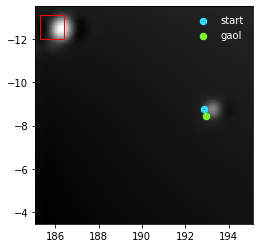

old value: 6.295669330378839
step: 0
96 60 108 76
The scan will take 19.7 seconds
atom moves by: 0.5191303311870532
value: 9.452185681584941
2.956516351206103


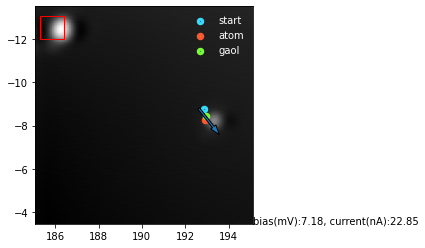

template_nm [185.32143156 -13.06914547]
step: 1
98 70 108 74
The scan will take 19.7 seconds
atom moves by: 0.4438440579492429
value: 9.996853887744578
0.34466820615963734


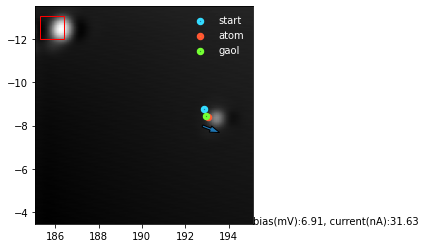

template_nm [185.32143156 -13.06914547]
atom moved by: 0.4088653491913002
Episode reward: 3.3011845573657403


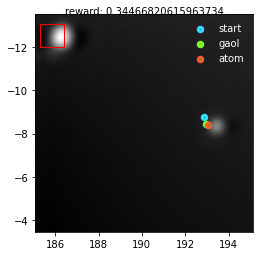

tensor([0.1171], device='cuda:0')


In [36]:
sac_train(max_steps=max_len, episode_start = 100,num_episodes = 1)

0.2158000324064272


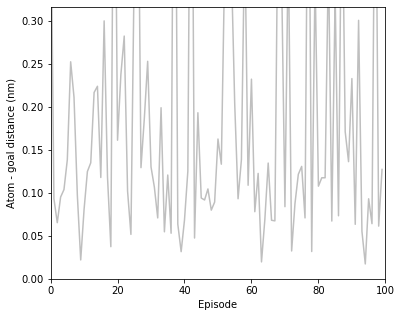

In [30]:
atom_destination_distance = []
angle = []
for i, np_name in enumerate(glob.glob('training_4/eval/*.npy')):
    try:
        data = np.load(np_name,allow_pickle=True).item()
        start_relative = data['episode_start_info']['info']['start_absolute_nm']
        destination_relative = data['episode_start_info']['info']['goal_absolute_nm']
        atom_relative = data['episode_end_info']['atom_absolute_nm']
        atom_destination_distance.append(np.linalg.norm(atom_relative - destination_relative))
        angle.append(np.arctan2((destination_relative-start_relative)[1],(destination_relative-start_relative)[0]))
    except:
        pass
n = 100
plt.subplots(figsize=(6,5))
avg_atom_destination_distance = np.convolve(atom_destination_distance, np.ones(n), mode='valid')/n
plt.plot(atom_destination_distance, color='gray', alpha=0.5)

plt.plot(avg_atom_destination_distance, linewidth=3, color='#B85C38')
plt.xlim([0,len(atom_destination_distance)])
plt.ylim([0,np.max(avg_atom_destination_distance)+0.1])
plt.xlabel('Episode')
plt.ylabel('Atom - goal distance (nm)')
print(avg_atom_destination_distance[-1])

In [35]:
len(atom_destination_distance)

100

78
64


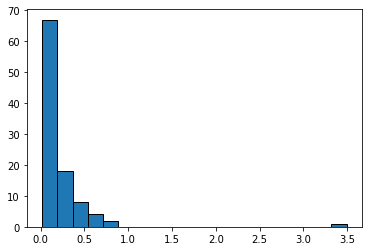

In [31]:
plt.hist(atom_destination_distance[-100:], bins=20, cumulative=False, edgecolor='black')
print(np.sum(np.array(atom_destination_distance[-100:])<0.28))
print(np.sum(np.array(atom_destination_distance[-100:])<0.1616))

Text(0, 0.5, 'Episode reward')

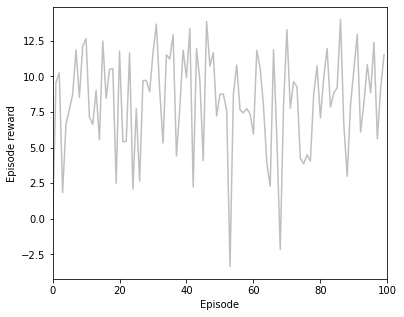

In [34]:
episode_rewards = []
for i, np_name in enumerate(glob.glob('training_4/eval/*.npy')):
    try:
        data = np.load(np_name,allow_pickle=True).item()
        episode_rewards.append(np.sum(data['transitions']['reward']))
    except:
        pass
avg_episode_rewards = np.convolve(episode_rewards, np.ones(n), mode='valid')/n
plt.subplots(figsize=(6,5))

plt.plot(episode_rewards, color='gray', alpha=0.5)
plt.plot(avg_episode_rewards, linewidth=3, color='#142F43')

plt.xlim([0,len(episode_rewards)])
#plt.ylim([np.min(avg_episode_rewards)-1,np.max(avg_episode_rewards)+1])
plt.xlabel('Episode')
plt.ylabel('Episode reward')